# Exploratory data analysis

## Data loading

In [124]:
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from matplotlib.ticker import PercentFormatter

# Load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Drop duplicates
df = df.drop_duplicates()

# Convert date to datetime
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Convert df['job_skills'] from a string to a list of strings
convert_skills = lambda x: ast.literal_eval(x) if pd.notna(x) else x
df['job_skills'] = df['job_skills'].apply(convert_skills)

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

In [125]:
# General information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 785640 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_title_short        785640 non-null  object        
 1   job_title              785639 non-null  object        
 2   job_location           784595 non-null  object        
 3   job_via                785632 non-null  object        
 4   job_schedule_type      772975 non-null  object        
 5   job_work_from_home     785640 non-null  bool          
 6   search_location        785640 non-null  object        
 7   job_posted_date        785640 non-null  datetime64[ns]
 8   job_no_degree_mention  785640 non-null  bool          
 9   job_health_insurance   785640 non-null  bool          
 10  job_country            785591 non-null  object        
 11  salary_rate            33066 non-null   object        
 12  salary_year_avg        22002 non-null   float64  

In [126]:
# Columns containing null values
df.isnull().sum()[df.isnull().sum() > 0]

job_title                 1
job_location           1045
job_via                   8
job_schedule_type     12665
job_country              49
salary_rate          752574
salary_year_avg      763638
salary_hour_avg      774978
company_name             18
job_skills           116986
job_type_skills      116986
dtype: int64

## General aspects

### Which roles have the most job postings?

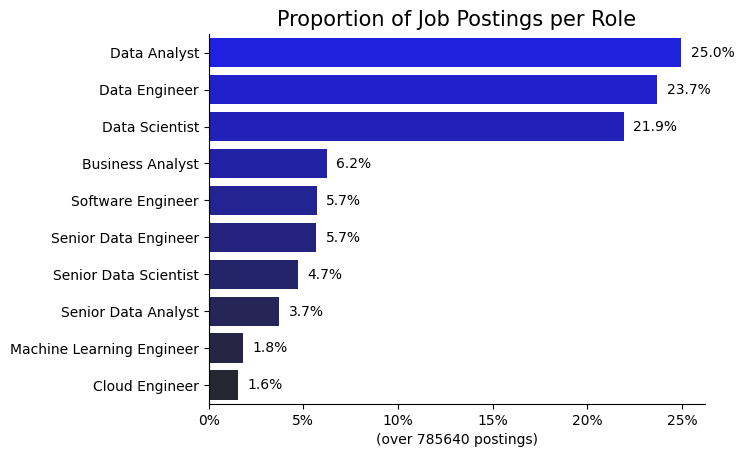

In [127]:
# Compute job count for each role
df_plot = df['job_title_short'].value_counts().to_frame()

# Use the total number of jobs to get the job proportion for each role
n_jobs = df_plot['count'].sum()
df_plot['proportion'] = 100*df_plot['count']/n_jobs

# Plot
sns.barplot(df_plot, x='proportion', y='job_title_short',
            hue='job_title_short', palette='dark:b_r', legend=False)
sns.despine()

# Add proportion values to each bar
for idx, val in enumerate(df_plot['proportion']):
    plt.text(val+0.5, idx, f'{val:.1f}%', va='center')

# Format percentages
plt.gca().xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.title('Proportion of Job Postings per Role', fontsize=15)
plt.xlabel(f'(over {n_jobs} postings)')
plt.ylabel('')

plt.savefig(os.path.join(output_directory, '1_1_proportion_job_postings_per_role.png'),
            bbox_inches='tight', dpi=600)
plt.show()

Breakdown:
- Three data roles account for almost 75% of all job postings.
- These three most popular data roles are **data analyst**, **data engineer** and **data scientist**.

### Which countries have the most job postings?

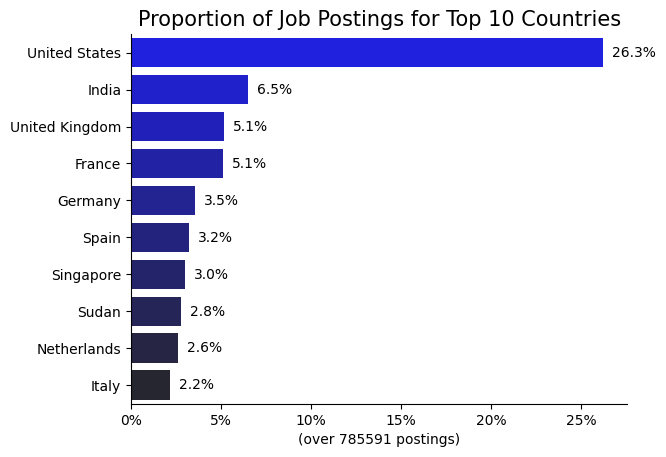

In [128]:
# Compute country count
df_plot = df['job_country'].value_counts().to_frame()

# Use the total number of jobs to get the job proportion for each role
n_jobs = df_plot['count'].sum()
df_plot['proportion'] = 100*df_plot['count']/n_jobs

# Isolate the top n_countries and plot
n_countries = 10
df_plot = df_plot.head(n_countries)

sns.barplot(df_plot, x='proportion', y='job_country',
            hue='job_country', palette='dark:b_r', legend=False)
sns.despine()
for idx, val in enumerate(df_plot['proportion']):
    plt.text(val+0.5, idx, f'{val:.1f}%', va='center')
plt.gca().xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.title(f'Proportion of Job Postings for Top {n_countries} Countries', fontsize=15)
plt.xlabel(f'(over {n_jobs} postings)')
plt.ylabel('')
plt.savefig(os.path.join(output_directory, '1_2_proportion_job_postings_top_countries.png'),
            bbox_inches='tight', dpi=600)
plt.show()

Data jobs in this dataset were mostly posted in the United States, which accounts for ~26% of all job postings.

### What is the median yearly salary for the top roles and countries?

In [129]:
# Let us identify the top countries/jobs before filtering out NaN values,
# to have the same top countries/jobs as above 
n_countries = 5
n_jobs = 3
top_countries = df['job_country'].value_counts().head(n_countries).index.to_list()
top_jobs = df['job_title_short'].value_counts().head(n_jobs).index.to_list()

# Only include entries that have non-null yearly salary values
df_relevant = df.dropna(subset=['salary_year_avg']).copy()

# Pivot to get the median salary
df_pivot = df_relevant.pivot_table(
    values='salary_year_avg',
    index='job_title_short',
    columns='job_country',
    aggfunc='median'
)

# Isolate the top n_countries and n_jobs
df_pivot = df_pivot[top_countries].loc[top_jobs]

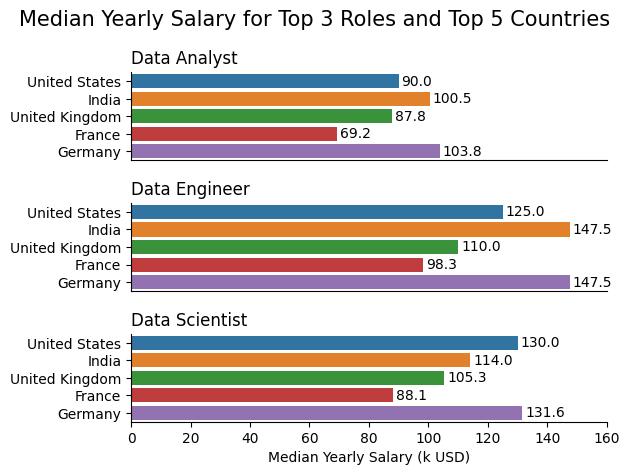

In [130]:
# Plot
fig, ax = plt.subplots(len(top_jobs), 1)
for i, job_title in enumerate(top_jobs):
    df_plot = df_pivot.loc[job_title].to_frame().reset_index()

    sns.barplot(df_plot, x = job_title, y='job_country',
                ax=ax[i], hue='job_country', legend=False)
    sns.despine()

    # Add values to each bar
    for idx, val in enumerate(df_plot[job_title]):   
        ax[i].text(val+1000, idx, f'{val/1000:.1f}', va='center')

    ax[i].set_title(job_title, loc='left')
    ax[i].set_ylabel('')
    ax[i].set_xlim(0, 160000)

    # For readability
    if i < len(top_jobs) - 1:
        ax[i].set_xticks([])
        ax[i].set_xlabel('')
    else:
        xtick_format = plt.FuncFormatter(lambda x, pos: f'{int(x/1000)}')
        ax[i].xaxis.set_major_formatter(xtick_format)
        ax[i].set_xlabel('Median Yearly Salary (k USD)')

fig.suptitle(f'Median Yearly Salary for Top {n_jobs} Roles and Top {n_countries} Countries',
             fontsize=15)
fig.tight_layout(h_pad=1.5)
plt.savefig(os.path.join(output_directory, '1_3_median_yearly_salary_top_roles_countries.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- Data-analyst job postings typically offer less salary than data-scientist and data-engineer ones.
- Data-engineer job postings tend to offer more salary than data-scientist ones.
- Germany generally offers higher salaries.
- France generally offers lower salaries.

## Personal interests

### Proportion of remote-work job postings for selected roles

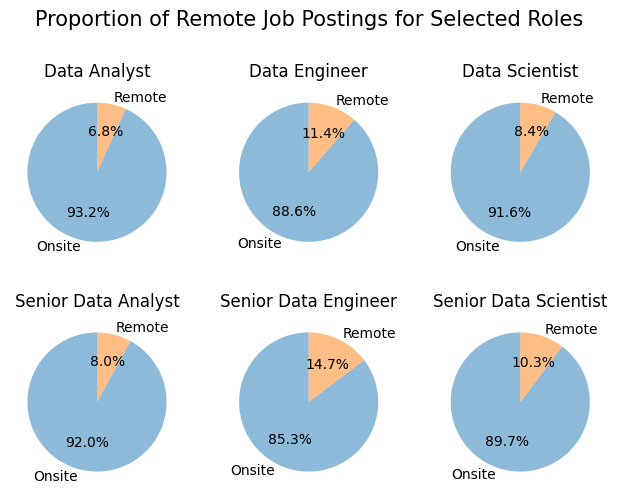

In [131]:
# Make copy
df_relevant = df.copy()

selected_jobs = [['Data Analyst', 'Data Engineer', 'Data Scientist'],
                 ['Senior Data Analyst', 'Senior Data Engineer', 'Senior Data Scientist']]

# Plot
fig, ax = plt.subplots(2, 3)
for i, job_titles in enumerate(selected_jobs):
    for j, job_title in enumerate(job_titles):
        df_plot = df_relevant[df_relevant['job_title_short'] == job_title]
        ax[i][j].pie(df_plot['job_work_from_home'].value_counts(),
                     labels=['Onsite', 'Remote'],
                     wedgeprops={"alpha": 0.5},
                     startangle=90,
                     autopct='%1.1f%%')
        ax[i][j].set_title(job_title)
plt.suptitle(f'Proportion of Remote Job Postings for Selected Roles',
             y=1.03, fontsize=15)
plt.tight_layout(h_pad = 4, w_pad = 1.2)
plt.savefig(os.path.join(output_directory, '1_4_proportion_remote_job_postings.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- Remote positions are a small fraction of all job postings, with a maximum of ~15% for senior-data-engineer job postings.
- Senior roles give more opportunities than standard roles for remote work, which may be due to the higher autonomy senior roles have. 
- Regardless of seniority level, data-analyst job postings have the smallest proportion of remote work and data-engineer job postings have the highest.

### Main Swedish employers for selected roles

Had we allowed for more countries in the above "Proportion of Job Postings for Top 10 Countries" graph, Sweden would have been 31st. Let us identify the top Swedish employers for selected roles based on job_count.

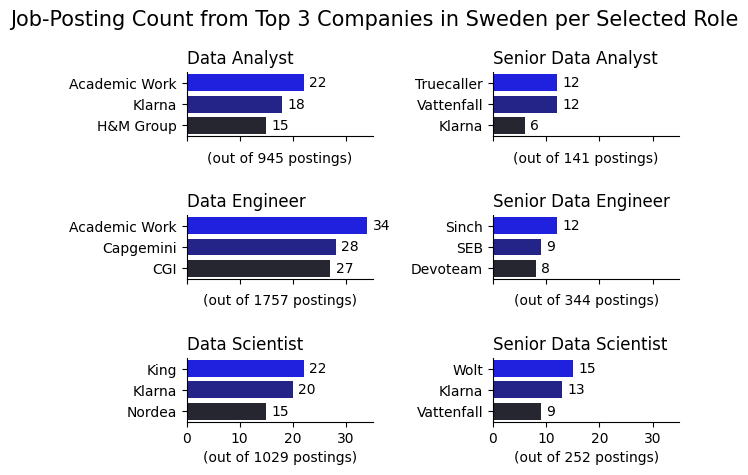

In [132]:
selected_jobs = [['Data Analyst', 'Senior Data Analyst'],
                   ['Data Engineer', 'Senior Data Engineer'],
                   ['Data Scientist', 'Senior Data Scientist']]
job_country = 'Sweden'
n_companies = 3

job_country_filename = job_country.lower().replace(' ', '_')

fig, ax = plt.subplots(len(selected_jobs), len(selected_jobs[0]))
for i, job_titles in enumerate(selected_jobs):
    for j, job_title in enumerate(job_titles):
        # Isolate relevant data
        idx = (df['job_title_short'] == job_title) \
                & (df['job_country'] == job_country)
        df_relevant = df[idx].copy()

        # Compute company count
        df_plot = df_relevant['company_name'].value_counts().to_frame()

        # Get total number of jobs
        n_jobs = df_plot['count'].sum()

        # Isolate the top n_company
        df_plot = df_plot.head(n_companies)

        # Plot
        sns.barplot(df_plot, x='count', y='company_name', ax=ax[i][j],
                    hue='company_name', palette='dark:b_r', legend=False)
        sns.despine()

        ax[i][j].set_title(job_title, loc='left')
        ax[i][j].set_ylabel('')
        ax[i][j].set_xlabel(f'(out of {n_jobs} postings)')
        ax[i][j].set_xlim(0, 35)

        # Add likelihood values to each bar
        for idx, val in enumerate(df_plot['count']):   
            ax[i][j].text(val+1, idx, val, va='center')

        # For readability
        if i < len(job_titles):
            ax[i][j].set_xticklabels([])

fig.suptitle(f'Job-Posting Count from Top {n_companies} Companies in {job_country} per Selected Role',
             fontsize=15)
fig.tight_layout(h_pad=2, w_pad=1.5)
plt.savefig(os.path.join(output_directory, '1_5_job_posting_count_top_companies_' + job_country_filename + '.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The fintech company **Klarna** is the most shared main employer across selected roles, namely for (senior)-data-analyst and (senior)-data-scientist roles.
- The recruitment and staffing company **Academic Work** is the top employer for data-analyst and data-engineer roles.
- The energy company **Vattenfall** is one of the main employers for both senior-data-analyst and senior-data-scientist roles.